setting seed, loading the dataset, and visualization

length of the lines dataset:  17289
shape of the lines dataset:  (17289, 7)
input and state dataset shape:  (17289, 3) (17289, 4)


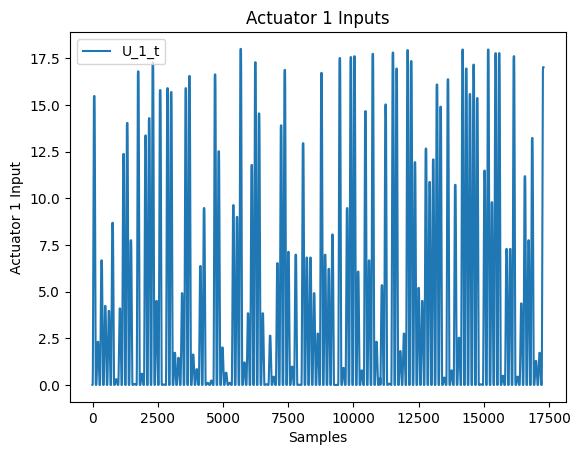

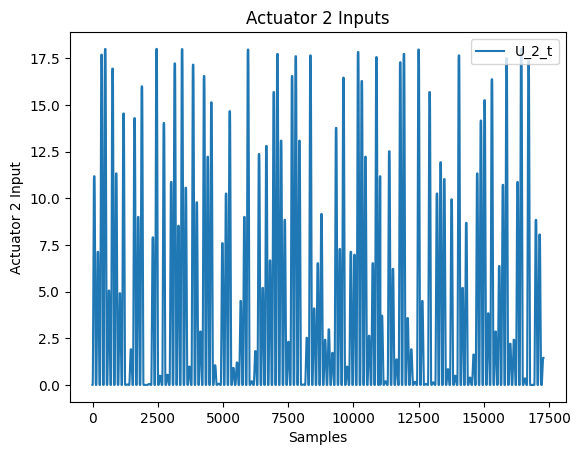

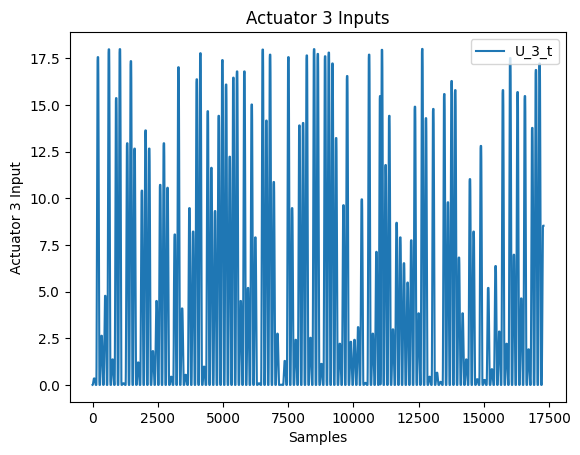

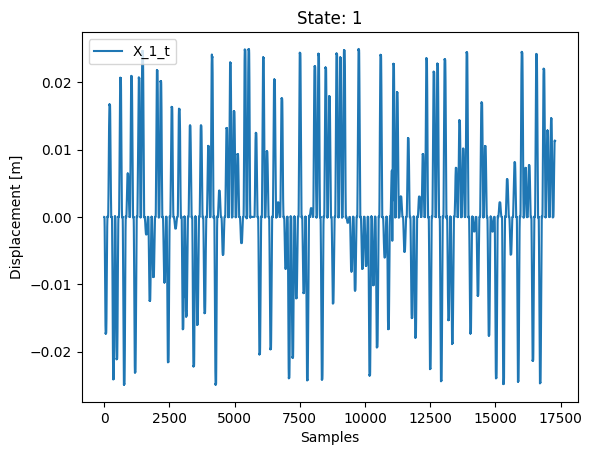

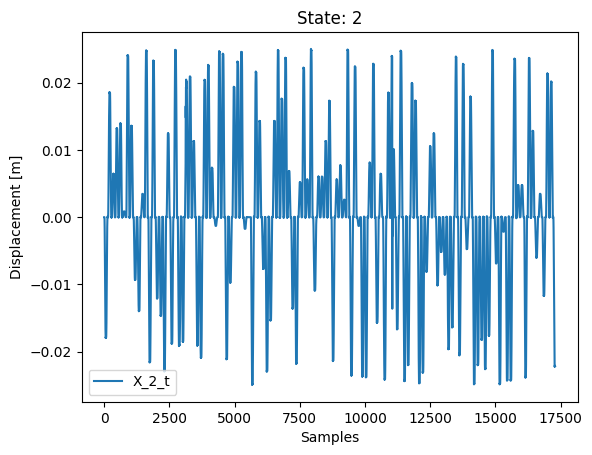

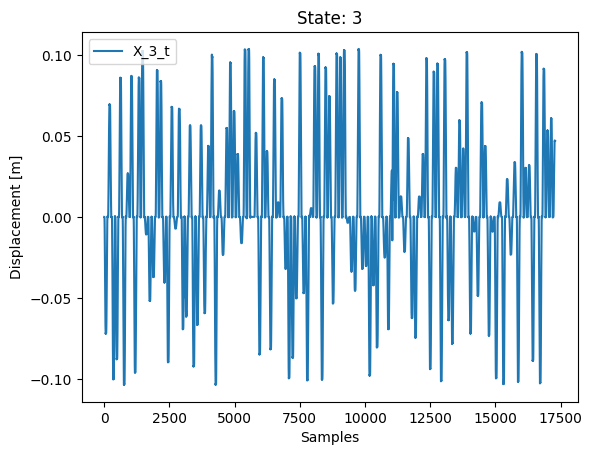

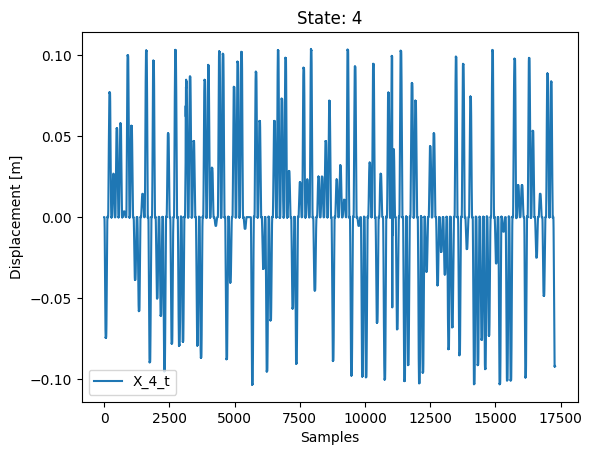

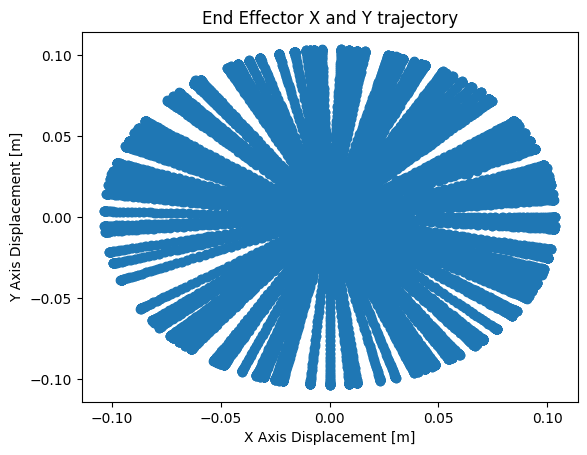

In [441]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import random
import torch 
import pandas as pd

def set_all_seeds(seed: int = 42):
    """
    Reinitializes seeds for Python, NumPy, and PyTorch to ensure reproducibility.
    """
    # 1. Python's built-in random module
    random.seed(seed)
    
    # 2. NumPy
    np.random.seed(seed)
    
    # 3. PyTorch (CPU)
    torch.manual_seed(seed)
# Usage:
set_all_seeds(42) 

script_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
dataset_path = os.path.join(script_directory, "logged_data_csv") 
line_dataset_filename = "linesrandom_124traj_20hz.csv"  
def load_data(file_path: str): 
    """
    Reads a csv and returns a numpy array of all the data 
    SETS THE INDEX TO THE TIME
    """
    df = pd.read_csv(file_path) 
    df.set_index('time',inplace=True)  
    df.drop(columns=["cs19_pos_z"], inplace=True) # removing the z axis
    df.drop(columns=["tip_pos_z"], inplace=True) 
    data = df.to_numpy() 
    return data 
lines_dataset = load_data(os.path.join(dataset_path, line_dataset_filename))  
print("length of the lines dataset: ", len(lines_dataset)) 
print("shape of the lines dataset: ", lines_dataset.shape) 

# following indices refers to the lines dataset
input_start_index = 0  
input_stop_index = 3 
state_start_index = 3 
state_stop_index = 7 

U = lines_dataset[:,input_start_index:input_stop_index] 
X= lines_dataset[:,state_start_index:state_stop_index]  
print("input and state dataset shape: ", U.shape, X.shape) 

# following indices refer to the U and X datasets
mid_x_index = 0 
mid_y_index = 1  
#mid_z_index = 2 
ee_x_index = 2 
ee_y_index = 3 
#ee_z_index = 5  
U1_index = 0 
U2_index = 1 
U3_index = 2

plt.figure() 
for i in range(U.shape[1]) : 
    plt.plot(U[:,i], label=f"U_{i+1}_t")  
    plt.legend()  
    plt.title(f"Actuator {i+1} Inputs") 
    plt.xlabel("Samples") 
    plt.ylabel(f"Actuator {i+1} Input")
    plt.show()
    plt.close()

for i in range(X.shape[1]) : 
    plt.figure() 
    plt.plot(X[:,i], label=f"X_{i+1}_t") 
    plt.legend()   
    plt.title(f"State: {i+1}") 
    plt.xlabel("Samples") 
    plt.ylabel("Displacement [m]")
    plt.show()
    plt.close()

plt.figure() 
plt.scatter(X[:,ee_x_index], X[:,ee_y_index]) 
plt.title("End Effector X and Y trajectory") 
plt.xlabel("X Axis Displacement [m]") 
plt.ylabel("Y Axis Displacement [m]") 
plt.show() 
plt.close()

train, validation and testing split

In [442]:
def train_valid_test_split(dataset: np.array, train_percent: int, valid_percent: int) : 
    len_data = len(dataset) 
    train_size = int(train_percent*len_data) 
    valid_size = int(valid_percent*len_data) 
    train_data = dataset[0:train_size] 
    valid_data = dataset[train_size:train_size+valid_size] 
    test_data = dataset[train_size+valid_size:] 
    return train_data, valid_data, test_data 

train_percent = 0.7 
valid_percent = 0.15 
test_percent = 0.15 

train_data, valid_data, test_data = train_valid_test_split(dataset=lines_dataset, train_percent=train_percent, valid_percent=valid_percent)  

print("training data shape: ", train_data.shape) 
print("validation data shape: ", valid_data.shape) 
print("testing data shape: ", test_data.shape) 

U_train = train_data[:,input_start_index:input_stop_index] 
X_train = train_data[:, state_start_index: state_stop_index] 
print("U and X train shape: ", U_train.shape, X_train.shape)

U_valid = valid_data[:,input_start_index:input_stop_index] 
X_valid = valid_data[:, state_start_index: state_stop_index] 
print("U and X valid shape: ", U_valid.shape, X_valid.shape)

U_test = test_data[:,input_start_index:input_stop_index] 
X_test = test_data[:, state_start_index: state_stop_index] 
print("U and X test shape: ", U_test.shape, X_test.shape)

training data shape:  (12102, 7)
validation data shape:  (2593, 7)
testing data shape:  (2594, 7)
U and X train shape:  (12102, 3) (12102, 4)
U and X valid shape:  (2593, 3) (2593, 4)
U and X test shape:  (2594, 3) (2594, 4)


scaling the dataset

In [443]:
from sklearn.preprocessing import MinMaxScaler 
data_scaler = MinMaxScaler(feature_range=(0,1)) 
input_scaler = MinMaxScaler(feature_range=(0,1)) 
state_scaler = MinMaxScaler(feature_range=(0,1))
ee_scaler = MinMaxScaler(feature_range=(0,1)) 
data_scaler.fit(train_data) 
input_scaler.fit(train_data[:,input_start_index:input_stop_index])   
state_scaler.fit(train_data[:,state_start_index:state_stop_index])
ee_scaler.fit(train_data[:,state_start_index+ee_x_index:state_stop_index])

train_data_transformed = data_scaler.transform(train_data) 
valid_data_transformed = data_scaler.transform(valid_data) 
test_data_transformed = data_scaler.transform(test_data) 


U_train_transformed = train_data_transformed[:,input_start_index:input_stop_index] 
X_train_transformed = train_data_transformed[:, state_start_index: state_stop_index] 
print("U and X train transformed shape: ", U_train_transformed.shape, X_train_transformed.shape)

U_valid_transformed = valid_data_transformed[:,input_start_index:input_stop_index] 
X_valid_transformed = valid_data_transformed[:, state_start_index: state_stop_index] 
print("U and X valid transformed shape: ", U_valid_transformed.shape, X_valid_transformed.shape)

U_test_transformed = test_data_transformed[:,input_start_index:input_stop_index] 
X_test_transformed = test_data_transformed[:, state_start_index: state_stop_index] 
print("U and X test transformed shape: ", U_test_transformed.shape, X_test_transformed.shape) 


future_feature = X_test_transformed[2:4,:]
future_feature.flatten('C').shape

U and X train transformed shape:  (12102, 3) (12102, 4)
U and X valid transformed shape:  (2593, 3) (2593, 4)
U and X test transformed shape:  (2594, 3) (2594, 4)


(8,)

preparing dataset, creating features and labels

In [444]:
def prepare_dataset(U: np.array, X: np.array, lag_input: int, lag_state: int, ee_x_index: int, ee_y_index: int) : 
    
    features = [] 
    labels = [] 

    max_lag = max(lag_input, lag_state)

    for i in range(max_lag, len(U)-1) : 
        future_feature = X[i+1,ee_x_index:ee_y_index+1] 
        current_feature = X[i,:] 
        if lag_state == 0 : 
            past_feature = X[i:i] 
        else : 
            past_feature = X[i-lag_state:i,:] 
            past_feature = past_feature.flatten('C')
        current_input = U[i,:] 
        if lag_input == 0 : 
            past_input = U[i:i]  
        else : 
            past_input = U[i-lag_input:i,:] 
            past_input = past_input.flatten('C') 
        
        if past_feature.size == 0 and past_input.size == 0 : 
            joined_features = np.concatenate((future_feature, current_feature, current_input), axis=0) 
        elif past_feature.size != 0 and past_input.size == 0 : 
            joined_features = np.concatenate((future_feature, current_feature, past_feature, current_input), axis=0)
        elif past_feature.size == 0 and past_input.size != 0 : 
            joined_features = np.concatenate((future_feature, current_feature, current_input, past_input), axis=0) 
        else : 
            joined_features = np.concatenate((future_feature, current_feature, past_feature, current_input, past_input), axis=0) 

        features.append(joined_features) 

        labels.append(U[i+1]) 
    
    features = np.array(features) 
    labels = np.array(labels)  

    return features, labels

In [445]:
lag_input = 0 
lag_state = 3 

train_features, train_labels = prepare_dataset(U=U_train_transformed, X=X_train_transformed, lag_input=lag_input, lag_state=lag_state,
                                               ee_x_index=ee_x_index, ee_y_index=ee_y_index) 
print("shape of the training features and labels: ", train_features.shape, train_labels.shape) 

valid_features, valid_labels = prepare_dataset(U=U_valid_transformed, X=X_valid_transformed, lag_input=lag_input, lag_state=lag_state,
                                               ee_x_index=ee_x_index, ee_y_index=ee_y_index) 
print("shape of the validation features and labels: ", valid_features.shape, valid_labels.shape) 

test_features, test_labels = prepare_dataset(U=U_test_transformed, X=X_test_transformed, lag_input=lag_input, lag_state=lag_state,
                                             ee_x_index=ee_x_index, ee_y_index=ee_y_index) 
print("shape of the testing features and labels: ", test_features.shape, test_labels.shape) 

shape of the training features and labels:  (12098, 21) (12098, 3)
shape of the validation features and labels:  (2589, 21) (2589, 3)
shape of the testing features and labels:  (2590, 21) (2590, 3)


conversion to tensor (torch.float32) and creation of dataloaders

In [446]:
import torch 

train_features_tensor = torch.from_numpy(train_features).type(dtype=torch.float32) 
train_labels_tensor = torch.from_numpy(train_labels).type(dtype=torch.float32) 
valid_features_tensor = torch.from_numpy(valid_features).type(dtype=torch.float32) 
valid_labels_tensor = torch.from_numpy(valid_labels).type(dtype=torch.float32) 
test_features_tensor = torch.from_numpy(test_features).type(dtype=torch.float32) 
test_labels_tensor = torch.from_numpy(test_labels).type(dtype=torch.float32) 

print("training feature and label tensor shape and datatype: ", train_features_tensor.shape, train_labels_tensor.shape, train_labels_tensor.dtype)
print("validation feature and label tensor shape and datatype: ", valid_features_tensor.shape, valid_labels_tensor.shape, valid_labels_tensor.dtype)
print("testing feature and label tensor shape and datatype: ", test_features_tensor.shape, test_labels_tensor.shape, test_labels_tensor.dtype) 

from torch.utils.data import TensorDataset, DataLoader 
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor) 
valid_dataset = TensorDataset(valid_features_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor) 

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size) 
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size) 

print("train dataloader length: ", len(train_dataloader)) 
print("valid dataloader length: ", len(valid_dataloader)) 
print("test dataloader length: ", len(test_dataloader)) 

for X,Y in train_dataloader : 
    print("shape of a single batch feature and label: ", X.shape, Y.shape)  
    break

training feature and label tensor shape and datatype:  torch.Size([12098, 21]) torch.Size([12098, 3]) torch.float32
validation feature and label tensor shape and datatype:  torch.Size([2589, 21]) torch.Size([2589, 3]) torch.float32
testing feature and label tensor shape and datatype:  torch.Size([2590, 21]) torch.Size([2590, 3]) torch.float32
train dataloader length:  757
valid dataloader length:  162
test dataloader length:  162
shape of a single batch feature and label:  torch.Size([16, 21]) torch.Size([16, 3])


defining and creating the network

In [447]:
class MLP_model(torch.nn.Module): 
    def __init__(self, input_flat_size:int, hidden_units:int, output_size:int, num_hidden_layers:int) :
        super().__init__()
        self.input_flat_size = input_flat_size 
        self.hidden_units = hidden_units 
        self.output_size = output_size 
        self.num_hidden_layers = num_hidden_layers 

        layers = [] 

        in_dimension = self.input_flat_size 

        self.input_layer = torch.nn.Linear(in_features=in_dimension, out_features=self.hidden_units) 
        
        for i in range(self.num_hidden_layers) : 
            layers.append(torch.nn.Linear(in_features=self.hidden_units, out_features=self.hidden_units)) 
            layers.append(torch.nn.ReLU()) 

        self.backbone = torch.nn.Sequential(*layers) 
        
        self.output_layer = torch.nn.Linear(in_features=self.hidden_units, out_features=self.output_size) 

        #self.tanh = torch.nn.Tanh() 
        self.relu = torch.nn.ReLU()
        #self.leakyrelu = torch.nn.LeakyReLU()    

    def forward(self,x): 
        out = self.input_layer(x) 
        out = self.relu(out)
        #out = self.backbone(out)  
        out = self.output_layer(out) 
        return out

In [448]:
input_flat_size = train_features.shape[1]
output_size = train_labels.shape[1] 

num_hidden_layers = 1
hidden_units = 30 

inverse_model = MLP_model(input_flat_size=input_flat_size, hidden_units=hidden_units, output_size=output_size, num_hidden_layers=num_hidden_layers) 

from torchinfo import summary 
print(summary(model=inverse_model, input_size=(1,input_flat_size)))

loss_fn = torch.nn.MSELoss() 
learning_rate_teacherforcing = 0.0001   
learning_rate_autoregressive = 0.0001 

optimizer_teacherforcing = torch.optim.Adam(inverse_model.parameters(), lr=learning_rate_teacherforcing) 
optimizer_autoregressive = torch.optim.Adam(inverse_model.parameters(), lr=learning_rate_autoregressive)

Layer (type:depth-idx)                   Output Shape              Param #
MLP_model                                [1, 3]                    930
├─Linear: 1-1                            [1, 30]                   660
├─ReLU: 1-2                              [1, 30]                   --
├─Linear: 1-3                            [1, 3]                    93
Total params: 1,683
Trainable params: 1,683
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


teacher forcing training function

In [449]:
def train_teacherforcing(model: torch.nn.Module, train_dataloader: DataLoader, valid_dataloader: DataLoader, 
                         optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module,
                         epochs: int, model_name: str, early_stopping_call = None) : 
    
    results = {"train_loss": [], "valid_loss": []} 

    for epoch in range(epochs) : 
        
        model.train() 

        total_loss_per_epoch = 0.0 

        for batch_num, (X,Y) in enumerate(train_dataloader) : 

            y_pred = model(X) 

            loss = loss_fn(y_pred, Y) 

            total_loss_per_epoch += loss.item() 

            optimizer.zero_grad() 

            loss.backward() 

            optimizer.step() 

        average_train_loss_per_epoch = total_loss_per_epoch/len(train_dataloader) 

        results["train_loss"].append(average_train_loss_per_epoch) 

        model.eval() 

        total_validation_loss_per_epoch = 0.0 

        with torch.inference_mode() : 
            
            for batch, (X_valid,Y_valid) in enumerate(valid_dataloader) : 

                y_pred_valid = model(X_valid) 

                loss = loss_fn(y_pred_valid, Y_valid) 

                total_validation_loss_per_epoch += loss.item() 
        
        average_valid_loss_per_epoch = total_validation_loss_per_epoch/len(valid_dataloader)
        
        results["valid_loss"].append(average_valid_loss_per_epoch) 

        print(
            f"{model_name} | "
            f"Epoch: {epoch + 1} | "
            f"Train Loss: {average_train_loss_per_epoch:.6f} | " # :.4f keep 4 decimal places 
            f"Validation_Loss: {average_valid_loss_per_epoch:.6f} | " 
        ) 

        if early_stopping_call is not None: 
            early_stopping_call(average_valid_loss_per_epoch)
            if early_stopping_call.early_stop : 
                print("Early Stopping Triggered") 
                break

    return results 

autoregressive training function

In [450]:
def train_autoregressive(model: torch.nn.Module, U_scaled_train: np.array, X_scaled_train: np.array, 
                         U_scaled_valid: np.array, X_scaled_valid: np.array, 
                         lag_input: int, lag_state: int, ee_x_index: int, ee_y_index: int, 
                         epochs: int, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, 
                         model_name: str, chunk_length: int, early_stopping_call = None):   
    
    results = {"train_loss": [], "valid_loss": []}

    U_train = torch.from_numpy(U_scaled_train).type(torch.float32)
    X_train = torch.from_numpy(X_scaled_train).type(torch.float32)
    U_valid = torch.from_numpy(U_scaled_valid).type(torch.float32)
    X_valid = torch.from_numpy(X_scaled_valid).type(torch.float32)  

    max_lag = max(lag_input, lag_state)

    for epoch in range(epochs): 

        U_train_buffer = U_train.clone()
        U_valid_buffer = U_valid.clone()

        model.train() 
        optimizer.zero_grad() 

        preds = []  
        labels = [] 

        total_loss = 0 
        step = 0  
        counter = 0

        # initial buffer filled with ground truth 
        future_state = X_train[max_lag+1,ee_x_index:ee_y_index+1] 
        current_state = X_train[max_lag,:] 
        if lag_state == 0 : 
            past_state = X_train[max_lag:max_lag] 
        else : 
            past_state = X_train[max_lag-lag_state:max_lag,:] 
            past_state = torch.flatten(input=past_state) 
        current_input = U_train[max_lag,:] 
        if lag_input == 0 : 
            past_input = U_train[max_lag:max_lag,:]
        else : 
            past_input = U_train[max_lag-lag_input:max_lag,:] 
            past_input = torch.flatten(input=past_input) 

        if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
            joined_features = torch.concatenate((future_state, current_state, current_input), dim=0) 
        elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
            joined_features = torch.concatenate((future_state, current_state, past_state, current_input), dim=0)
        elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
            joined_features = torch.concatenate((future_state, current_state, current_input, past_input), dim=0) 
        else : 
            joined_features = torch.concatenate((future_state, current_state, past_state, current_input, past_input), dim=0)  

        for i in range(max_lag+1, len(U_train)) : 

            pred = model(joined_features.unsqueeze(0)) 
            pred = pred.squeeze(0) 

            step += 1 

            preds.append(pred)  

            labels.append(U_train[i])

            U_train_buffer[i,:] = pred  

            if i < len(U_train) - 1 :

                # buffer update 
                future_state = X_train[i+1,ee_x_index:ee_y_index+1]
                current_state = X_train[i,:]
                if lag_state == 0 : 
                    past_state = X_train[i:i] 
                else : 
                    past_state = X_train[i-lag_state:i,:] 
                    past_state = torch.flatten(input=past_state)
                current_input = pred 
                if lag_input == 0 : 
                    past_input = U_train[i:i,:]
                else : 
                    past_input = U_train_buffer[i-lag_input:i,:] 
                    past_input = torch.flatten(input=past_input) 

                if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
                    joined_features = torch.concatenate((future_state, current_state, current_input), dim=0) 
                elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
                    joined_features = torch.concatenate((future_state, current_state, past_state, current_input), dim=0)
                elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
                    joined_features = torch.concatenate((future_state, current_state, current_input, past_input), dim=0) 
                else : 
                    joined_features = torch.concatenate((future_state, current_state, past_state, current_input, past_input), dim=0) 

            else : 
                pass  

            if step == chunk_length or i == len(U_train) - 1:  

                preds_tensor = torch.stack(preds, dim=0)  

                labels_tensor = torch.stack(labels, dim=0)

                loss = loss_fn(preds_tensor, labels_tensor)  

                loss.backward() 
                total_loss += loss.item()
                optimizer.step()  
                optimizer.zero_grad()


                current_input = current_input.detach() 
                U_train_buffer = U_train_buffer.detach() 
                joined_features = joined_features.detach()

                total_loss += loss.item() 
                
                step = 0 
                preds = [] 
                labels = []   
                counter += 1  
            else : 
                pass

        train_loss = total_loss/counter

        # validation 
        model.eval() 

        preds = []

        # initial buffer filled with ground truth 
        future_state = X_valid[max_lag+1,ee_x_index:ee_y_index+1] 
        current_state = X_valid[max_lag,:] 
        if lag_state == 0 : 
            past_state = X_valid[max_lag:max_lag] 
        else : 
            past_state = X_valid[max_lag-lag_state:max_lag,:] 
            past_state = torch.flatten(input=past_state) 
        current_input = U_valid[max_lag,:] 
        if lag_input == 0 : 
            past_input = U_valid[max_lag:max_lag,:]
        else : 
            past_input = U_valid[max_lag-lag_input:max_lag,:] 
            past_input = torch.flatten(input=past_input) 

        if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
            joined_features = torch.concatenate((future_state, current_state, current_input), dim=0) 
        elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
            joined_features = torch.concatenate((future_state, current_state, past_state, current_input), dim=0)
        elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
            joined_features = torch.concatenate((future_state, current_state, current_input, past_input), dim=0) 
        else : 
            joined_features = torch.concatenate((future_state, current_state, past_state, current_input, past_input), dim=0) 
        
        with torch.inference_mode() :  

            for i in range(max_lag+1, len(U_valid)) : 

                pred = model(joined_features.unsqueeze(0)) 
                pred = pred.squeeze(0) 

                preds.append(pred) 

                U_valid_buffer[i,:] = pred  

                if i < len(U_valid) - 1 : 

                    # buffer update 
                    future_state = X_valid[i+1,ee_x_index:ee_y_index+1]
                    current_state = X_valid[i,:]
                    if lag_state == 0 : 
                        past_state = X_valid[i:i] 
                    else : 
                        past_state = X_valid[i-lag_state:i,:] 
                        past_state = torch.flatten(input=past_state)
                    current_input = pred 
                    if lag_input == 0 : 
                        past_input = U_valid[i:i,:]
                    else : 
                        past_input = U_valid_buffer[i-lag_input:i,:] 
                        past_input = torch.flatten(input=past_input)  

                    if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
                        joined_features = torch.concatenate((future_state, current_state, current_input), dim=0) 
                    elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
                        joined_features = torch.concatenate((future_state, current_state, past_state, current_input), dim=0)
                    elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
                        joined_features = torch.concatenate((future_state, current_state, current_input, past_input), dim=0) 
                    else : 
                        joined_features = torch.concatenate((future_state, current_state, past_state, current_input, past_input), dim=0)
                     

                else : 
                    pass

        preds_tensor = torch.stack(preds, dim=0) 

        targets = U_valid[max_lag+1:] 

        loss = loss_fn(preds_tensor, targets) 

        valid_loss = loss.item() 

        print(
        f"Model: {model_name} |"
        f"Epoch: {epoch + 1} | "
        f"Train Loss: {train_loss:.6f} | " 
        f"Validation_Loss: {valid_loss:.6f} | " 
        ) 

        results["train_loss"].append(train_loss) 
        results["valid_loss"].append(valid_loss)

        if early_stopping_call is not None: 
            early_stopping_call(valid_loss) 
            if early_stopping_call.early_stop : 
                print("Early Stopping Triggered") 
                break 

    return results

defining early stopping function

In [451]:
class EarlyStopping:
    def __init__(self, patience=6, min_delta=0.0):
        """
        patience: number of epochs to wait for improvement
        min_delta: minimum improvement in validation loss to count as progress
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

initializing the training

In [452]:
epochs_teacherforcing = 2000
epochs_autoregressive = 2000 

model_name_tf = "MLP_IK_TF" 
model_name_ar = "MLP_IK_AR" 

early_stoppper_tf = EarlyStopping(patience=6, min_delta=0)
early_stoppper_ar = EarlyStopping(patience=6, min_delta=0) 

chunk_length = 10 

'''
train_results_tf = train_teacherforcing(model=inverse_model, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, optimizer=optimizer_teacherforcing, 
                                        loss_fn=loss_fn, epochs=epochs_teacherforcing, model_name=model_name_tf, early_stopping_call=early_stoppper_tf)
                                        '''


train_results_ar = train_autoregressive(model=inverse_model, U_scaled_train=U_train_transformed, X_scaled_train=X_train_transformed,
                                        U_scaled_valid=U_valid_transformed, X_scaled_valid=X_valid_transformed, lag_input=lag_input, lag_state=lag_state,
                                        ee_x_index=ee_x_index, ee_y_index=ee_y_index, 
                                        epochs=epochs_autoregressive, optimizer=optimizer_autoregressive, loss_fn=loss_fn, model_name=model_name_ar, chunk_length=chunk_length , early_stopping_call=early_stoppper_ar) 

Model: MLP_IK_AR |Epoch: 1 | Train Loss: 0.169910 | Validation_Loss: 0.074457 | 
Model: MLP_IK_AR |Epoch: 2 | Train Loss: 0.131310 | Validation_Loss: 0.059818 | 
Model: MLP_IK_AR |Epoch: 3 | Train Loss: 0.105177 | Validation_Loss: 0.045238 | 
Model: MLP_IK_AR |Epoch: 4 | Train Loss: 0.083986 | Validation_Loss: 0.036504 | 
Model: MLP_IK_AR |Epoch: 5 | Train Loss: 0.069421 | Validation_Loss: 0.029744 | 
Model: MLP_IK_AR |Epoch: 6 | Train Loss: 0.057860 | Validation_Loss: 0.024601 | 
Model: MLP_IK_AR |Epoch: 7 | Train Loss: 0.049517 | Validation_Loss: 0.021365 | 
Model: MLP_IK_AR |Epoch: 8 | Train Loss: 0.044297 | Validation_Loss: 0.019364 | 
Model: MLP_IK_AR |Epoch: 9 | Train Loss: 0.041112 | Validation_Loss: 0.017884 | 
Model: MLP_IK_AR |Epoch: 10 | Train Loss: 0.038498 | Validation_Loss: 0.016665 | 
Model: MLP_IK_AR |Epoch: 11 | Train Loss: 0.036020 | Validation_Loss: 0.014983 | 
Model: MLP_IK_AR |Epoch: 12 | Train Loss: 0.033698 | Validation_Loss: 0.013825 | 
Model: MLP_IK_AR |Epoch: 

plot of training and validation losses

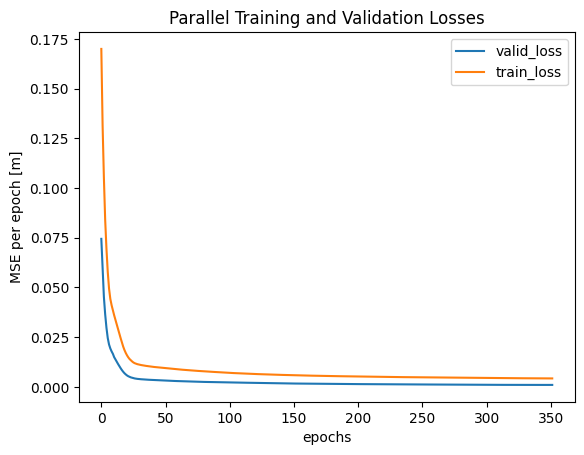

In [453]:
plt.figure()
#plt.plot(train_results_tf["train_loss"], label="train_loss") 
plt.plot(train_results_ar["valid_loss"], label="valid_loss")  
plt.plot(train_results_ar["train_loss"], label="train_loss")
plt.xlabel("epochs") 
plt.ylabel("MSE per epoch [m]")   
plt.title("Parallel Training and Validation Losses")
plt.legend()

plotting teacher forcing results

In [454]:
def teacherforcing_performance_plot(model : torch.nn.Module, dataloader : DataLoader, loss_fn: torch.nn, dataset_name : str) : 
    labels = [] 
    preds = [] 
    model.eval() 
    total_loss = 0.0
    with torch.inference_mode() : 
        for X , y in dataloader : 
            # forward pass 
            pred = model(X) 
            # appending 
            labels.append(y) 
            preds.append(pred) 
            # calculating the loss 
            loss = loss_fn(pred, y)
            total_loss += loss.item()

    average_loss = total_loss/len(dataloader)
    print("loss: ", average_loss) 

    labels = np.concatenate(labels, axis=0) 
    preds = np.concatenate(preds, axis=0)

    plt.figure() 
    plt.plot(labels[:,0], label='True U1') 
    plt.plot(preds[:,0], label='Predicted U1', linestyle='--')  
    plt.legend()
    plt.title(f"U_1_{dataset_name}"); 
    plt.xlabel('Sample'); 
    plt.ylabel('Value') 

    plt.figure()
    plt.plot(labels[:, 1], label='True U2')
    plt.plot(preds[:, 1],  label='Predicted U2', linestyle='--')
    plt.legend()
    plt.title(f"U_2_{dataset_name}")
    plt.xlabel('Sample')
    plt.ylabel('Value')

    plt.figure()
    plt.plot(labels[:, 2], label='True U3')
    plt.plot(preds[:, 2],  label='Predicted U3', linestyle='--')
    plt.legend()
    plt.title(f"U_3_{dataset_name}")
    plt.xlabel('Sample')
    plt.ylabel('Value') 

loss:  0.0014260126759605889
loss:  0.0006686122477181072
loss:  0.0005152937617620208


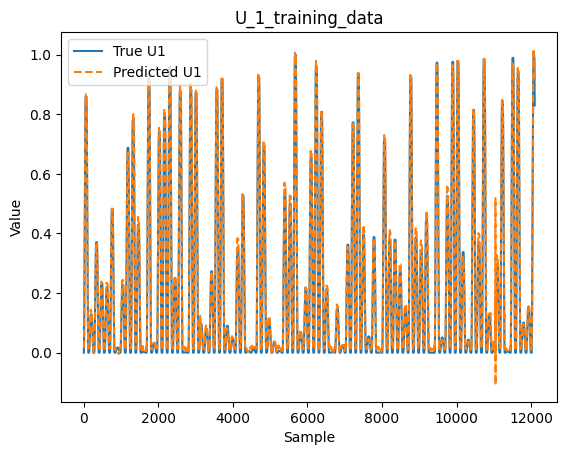

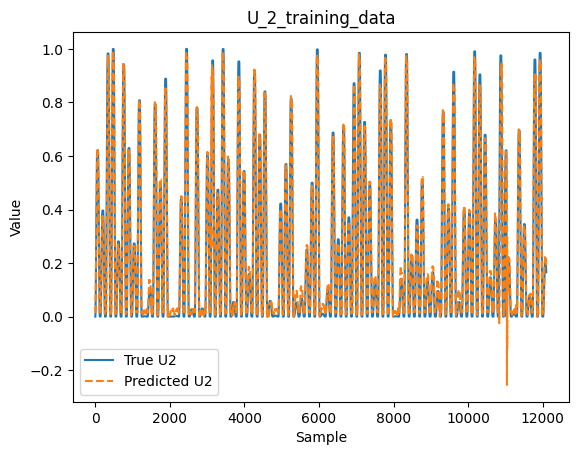

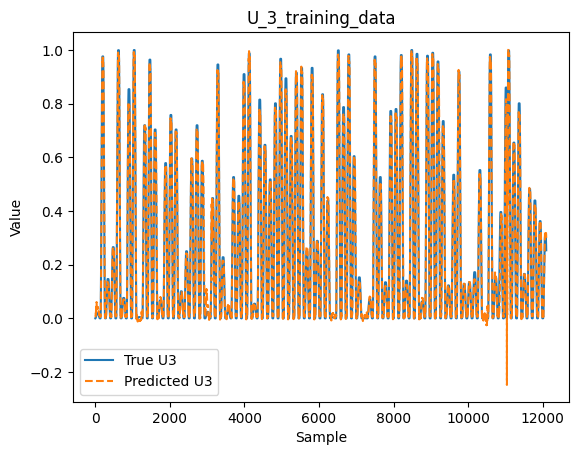

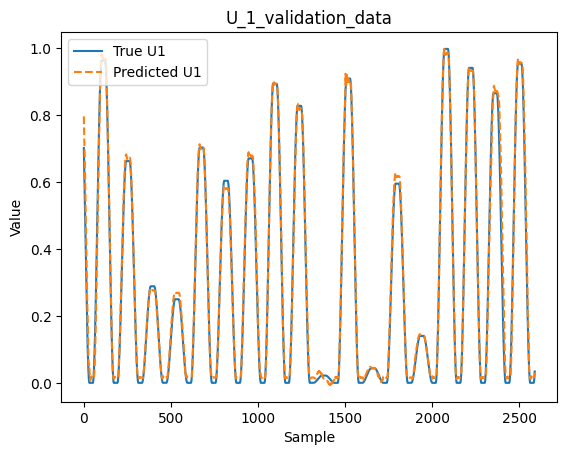

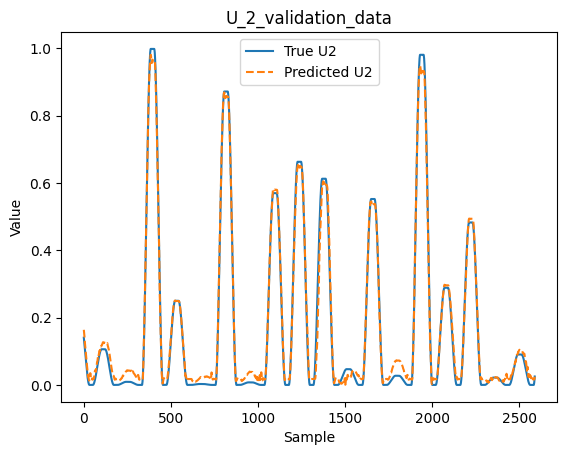

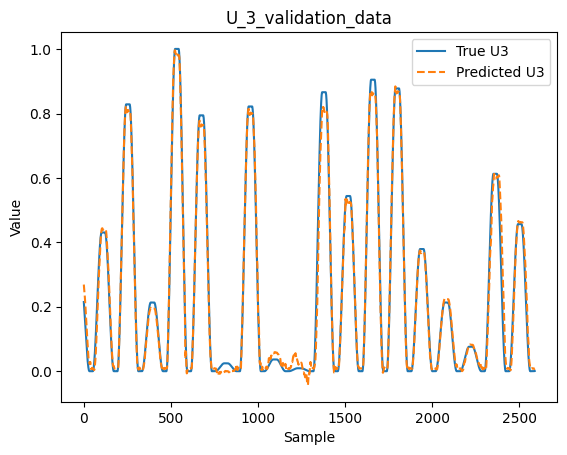

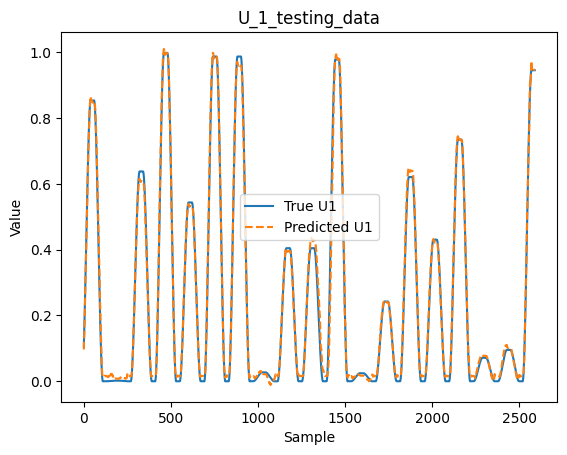

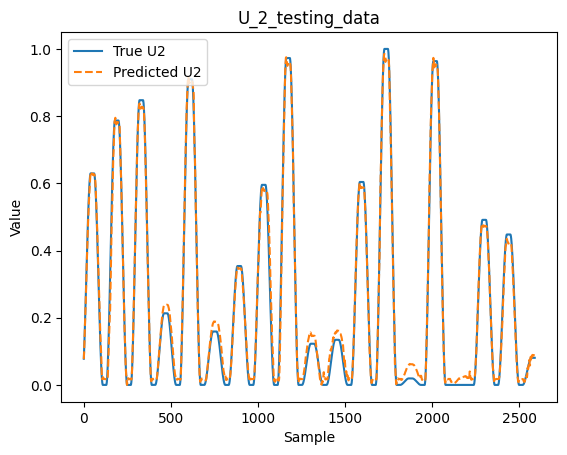

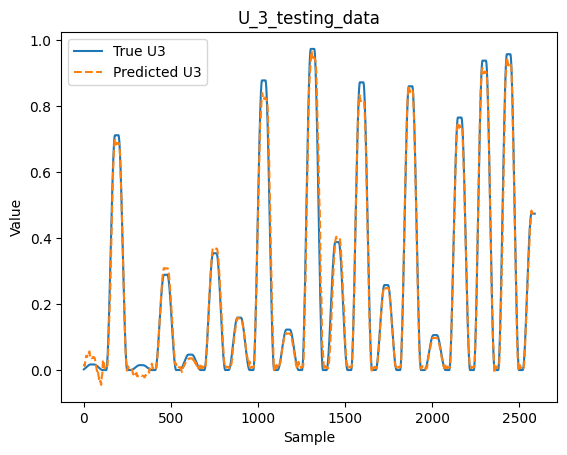

In [455]:
teacherforcing_performance_plot(model=inverse_model, dataloader=train_dataloader, loss_fn=loss_fn, dataset_name="training_data")
teacherforcing_performance_plot(model=inverse_model, dataloader=valid_dataloader,  loss_fn=loss_fn, dataset_name="validation_data")
teacherforcing_performance_plot(model=inverse_model, dataloader=test_dataloader,  loss_fn=loss_fn, dataset_name="testing_data")

plotting autoregressive results

In [456]:
def autoregressive_performance_plot(model: torch.nn.Module, U_scaled: np.array, X_scaled: np.array,  
                                    lag_input: int, lag_state: int, ee_x_index: int, ee_y_index: int, 
                                    loss_fn: torch.nn.Module, 
                                    dataset_name: str, U1_index: int, U2_index: int, U3_index: int, 
                                    early_stopping_call = None): 

    model.eval()  

    U = torch.from_numpy(U_scaled).type(torch.float32)
    X = torch.from_numpy(X_scaled).type(torch.float32)  

    U_buffer = U.clone()

    max_lag = max(lag_input, lag_state)
     
    preds = [] 

    # initial buffer filled with ground truth 
    future_state = X[max_lag+1,ee_x_index:ee_y_index+1] 
    current_state = X[max_lag,:] 
    if lag_state == 0 : 
        past_state = X[max_lag:max_lag] 
    else : 
        past_state = X[max_lag-lag_state:max_lag,:] 
        past_state = torch.flatten(input=past_state) 
    current_input = U[max_lag,:] 
    if lag_input == 0 : 
        past_input = U[max_lag:max_lag,:]
    else : 
        past_input = U[max_lag-lag_input:max_lag,:] 
        past_input = torch.flatten(input=past_input) 

    if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
        joined_features = torch.concatenate((future_state, current_state, current_input), dim=0) 
    elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
        joined_features = torch.concatenate((future_state, current_state, past_state, current_input), dim=0)
    elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
        joined_features = torch.concatenate((future_state, current_state, current_input, past_input), dim=0) 
    else : 
        joined_features = torch.concatenate((future_state, current_state, past_state, current_input, past_input), dim=0)  

    with torch.inference_mode() : 

        for i in range(max_lag+1, len(U)) : 

            pred = model(joined_features.unsqueeze(0)) 
            pred = pred.squeeze(0)

            preds.append(pred) 

            U_buffer[i,:] = pred 

            if i < len(U) - 1 :
                # buffer update 
                future_state = X[i+1,ee_x_index:ee_y_index+1]
                current_state = X[i,:]
                if lag_state == 0 : 
                    past_state = X[i:i] 
                else : 
                    past_state = X[i-lag_state:i,:] 
                    past_state = torch.flatten(input=past_state)
                current_input = pred 
                if lag_input == 0 : 
                    past_input = U[i:i,:]
                else : 
                    past_input = U_buffer[i-lag_input:i,:] 
                    past_input = torch.flatten(input=past_input) 

                if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
                    joined_features = torch.concatenate((future_state, current_state, current_input), dim=0) 
                elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
                    joined_features = torch.concatenate((future_state, current_state, past_state, current_input), dim=0)
                elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
                    joined_features = torch.concatenate((future_state, current_state, current_input, past_input), dim=0) 
                else : 
                    joined_features = torch.concatenate((future_state, current_state, past_state, current_input, past_input), dim=0)
            
            else : 
                pass
            

    preds_tensor = torch.stack(preds, dim=0) 

    targets = U[max_lag+1:] 

    loss = loss_fn(preds_tensor, targets)  

    average_loss = loss.item()  

    print(f"Average Loss of {dataset_name}: {average_loss}")

    plt.figure() 
    plt.plot(targets[:,U1_index], label='True U1') 
    plt.plot(preds_tensor[:,U1_index], label='Predicted U1', linestyle='--')  
    plt.legend()
    plt.title(f"U_1_{dataset_name}"); 
    plt.xlabel('Sample'); 
    plt.ylabel('Value') 

    plt.figure()
    plt.plot(targets[:, U2_index], label='True U2')
    plt.plot(preds_tensor[:, U2_index],  label='Predicted U2', linestyle='--')
    plt.legend()
    plt.title(f"U_2_{dataset_name}")
    plt.xlabel('Sample')
    plt.ylabel('Value')

    plt.figure()
    plt.plot(targets[:, U3_index], label='True U3')
    plt.plot(preds_tensor[:, U3_index],  label='Predicted U3', linestyle='--')
    plt.legend()
    plt.title(f"U_3_{dataset_name}")
    plt.xlabel('Sample')
    plt.ylabel('Value')

    return average_loss

Average Loss of train_data: 0.001998001942411065
Average Loss of valid_data: 0.0010401406325399876
Average Loss of test_data: 0.0009011930087581277


0.0009011930087581277

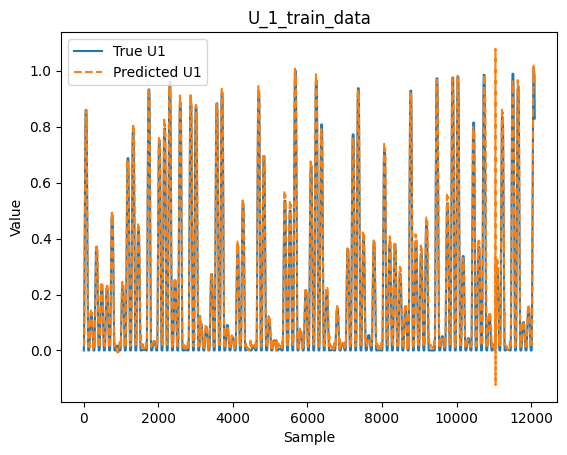

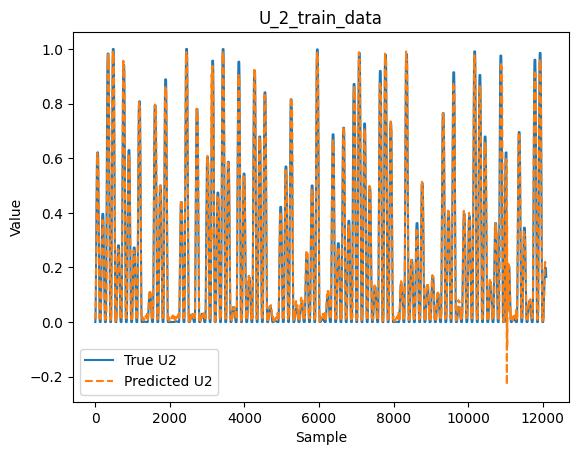

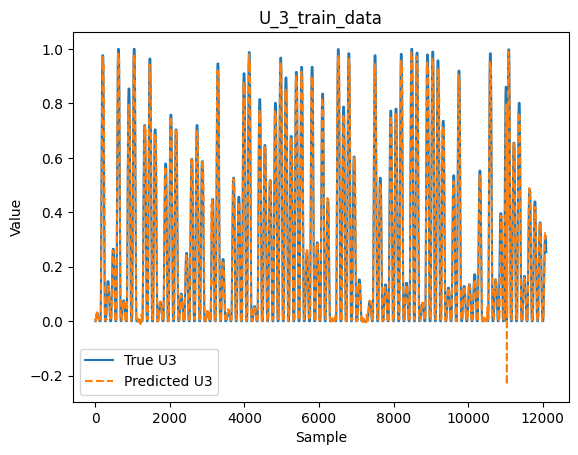

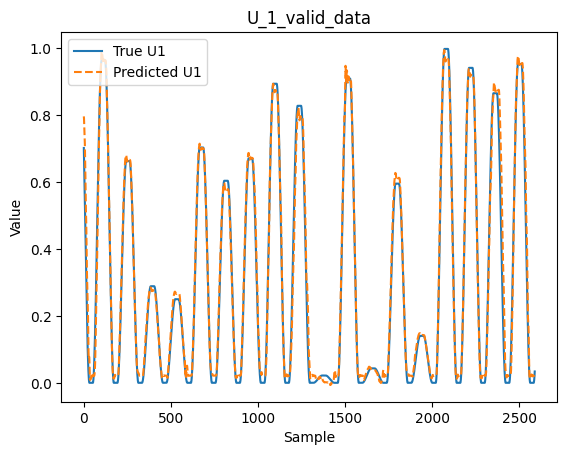

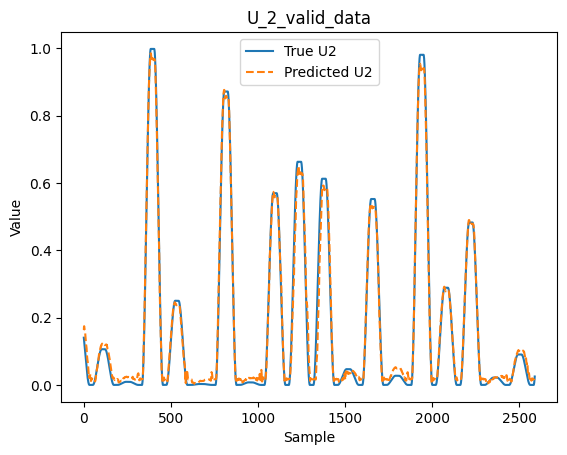

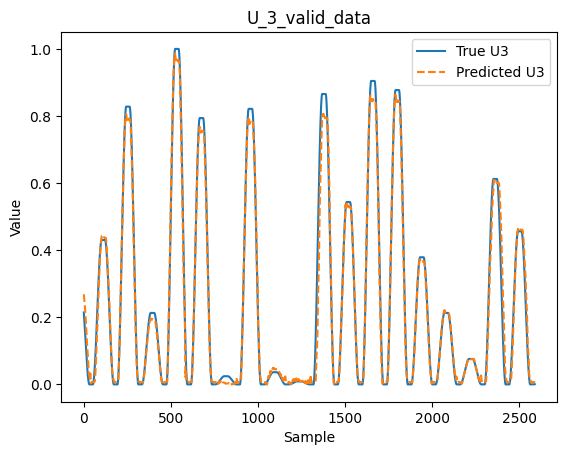

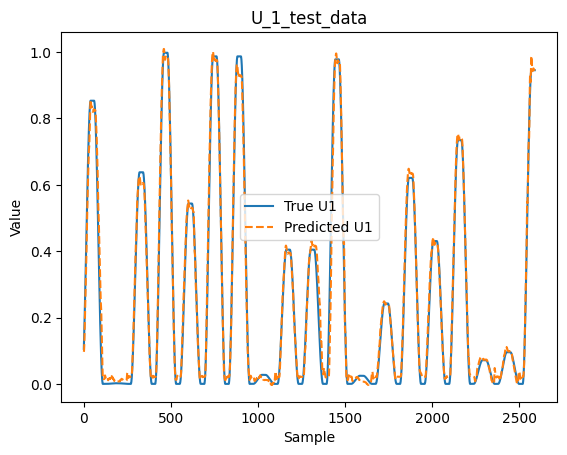

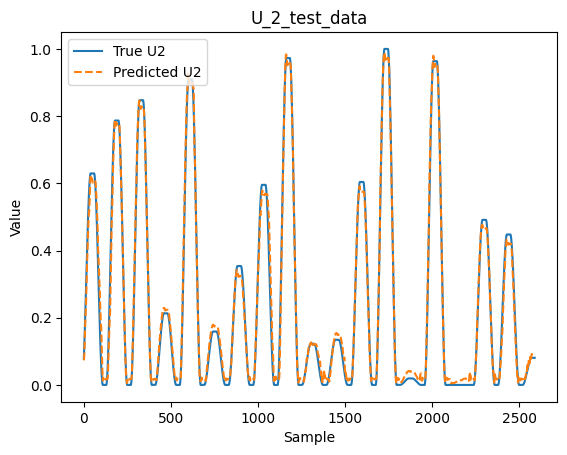

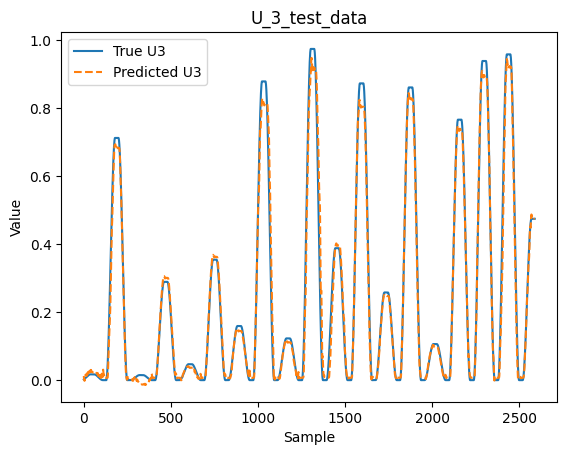

In [457]:
autoregressive_performance_plot(model=inverse_model, U_scaled=U_train_transformed, X_scaled=X_train_transformed, lag_input=lag_input, lag_state=lag_state,
                                ee_x_index=ee_x_index, ee_y_index=ee_y_index,
                                loss_fn=loss_fn, U1_index=U1_index, U2_index=U2_index, U3_index=U3_index, 
                                dataset_name="train_data") 

autoregressive_performance_plot(model=inverse_model, U_scaled=U_valid_transformed, X_scaled=X_valid_transformed, lag_input=lag_input, lag_state=lag_state,
                                ee_x_index=ee_x_index, ee_y_index=ee_y_index,
                                loss_fn=loss_fn, U1_index=U1_index, U2_index=U2_index, U3_index=U3_index, 
                                dataset_name="valid_data") 

autoregressive_performance_plot(model=inverse_model, U_scaled=U_test_transformed, X_scaled=X_test_transformed, lag_input=lag_input, lag_state=lag_state,
                                ee_x_index=ee_x_index, ee_y_index=ee_y_index,
                                loss_fn=loss_fn, U1_index=U1_index, U2_index=U2_index, U3_index=U3_index, 
                                dataset_name="test_data")

saving the model

In [458]:
model_data_directory = os.path.join(script_directory, "ik_model_lines_data")
os.makedirs(model_data_directory, exist_ok=True)
model_name = "IK_MLP_lines.pth" 
torch.save(inverse_model.state_dict(), os.path.join(model_data_directory, model_name))

saving the scalers

In [459]:
import pickle
data_scaler_filename = "data_scaler_lines.pkl"
input_scaler_filename = "input_scaler_lines.pkl" 
state_scaler_filename = "state_scaler_lines.pkl" 
ee_scaler_filename = "ee_xy_scaler.pkl"
with open(os.path.join(model_data_directory, data_scaler_filename), "wb") as file : 
    pickle.dump(data_scaler, file=file) 
with open(os.path.join(model_data_directory, input_scaler_filename), "wb") as file : 
    pickle.dump(input_scaler, file=file)
with open(os.path.join(model_data_directory, state_scaler_filename), "wb") as file : 
    pickle.dump(state_scaler, file=file)
with open(os.path.join(model_data_directory, ee_scaler_filename), "wb") as file : 
    pickle.dump(ee_scaler, file=file)